In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content'

In [2]:
import matplotlib.pyplot as plt

In [3]:

!kaggle datasets download -d maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset
License(s): other
100% 686M/688M [00:22<00:00, 39.7MB/s]
100% 688M/688M [00:22<00:00, 32.4MB/s]


In [4]:
!unzip /content/covid19-ct-scan-lesion-segmentation-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: frames/Jun_coronacases_case2_63.png  
  inflating: frames/Jun_coronacases_case2_64.png  
  inflating: frames/Jun_coronacases_case2_65.png  
  inflating: frames/Jun_coronacases_case2_66.png  
  inflating: frames/Jun_coronacases_case2_67.png  
  inflating: frames/Jun_coronacases_case2_68.png  
  inflating: frames/Jun_coronacases_case2_69.png  
  inflating: frames/Jun_coronacases_case2_70.png  
  inflating: frames/Jun_coronacases_case2_71.png  
  inflating: frames/Jun_coronacases_case2_72.png  
  inflating: frames/Jun_coronacases_case2_73.png  
  inflating: frames/Jun_coronacases_case2_74.png  
  inflating: frames/Jun_coronacases_case2_75.png  
  inflating: frames/Jun_coronacases_case2_76.png  
  inflating: frames/Jun_coronacases_case2_77.png  
  inflating: frames/Jun_coronacases_case2_78.png  
  inflating: frames/Jun_coronacases_case2_79.png  
  inflating: frames/Jun_coronacases_case2_80.png  
  inflating: frames/Jun_coronac

importing libraries


In [5]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
img_dir= '/content/frames' #images directory

In [7]:
masks_dir= '/content/masks' #mask directory

In [54]:
images_listdir = os.listdir(img_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False) #selection of 9 random images

In [67]:
#hyperparameter
image_size=512
input_image_size=(224,224)

In [68]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

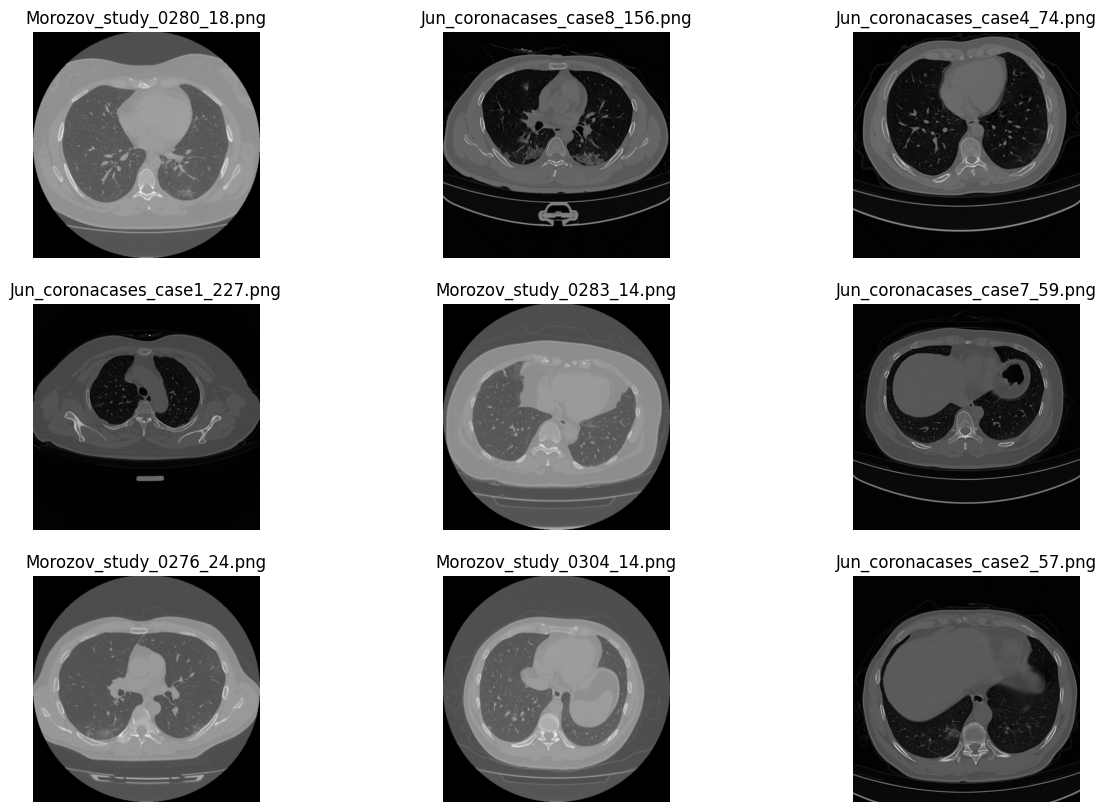

In [69]:
#displaying random images from images dataset
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (15,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{img_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

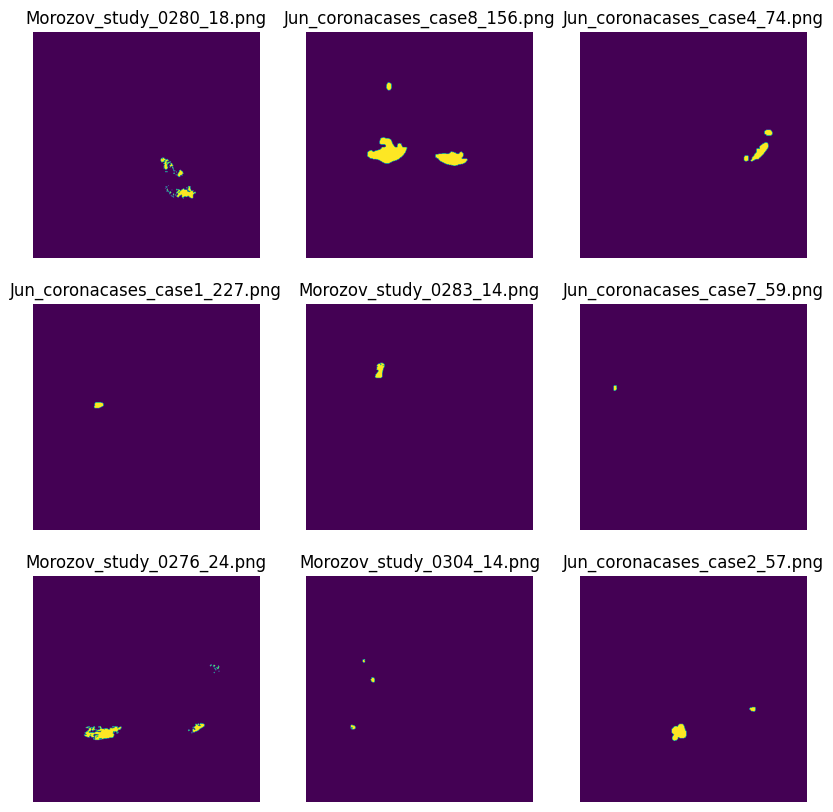

In [70]:
#displaying random images from mask dataset
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [187]:
number= 50

In [188]:
#stacking the images into array (preprocessing)
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{img_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [189]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(50, 512, 512, 3) (50, 512, 512, 1)


In [190]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42) #splitting the datset into train and test data

In [191]:
print(len(images_train), len(masks_train))

30 30


Model building- UNET MODEL

In [192]:
#defing the layers for the model
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size=3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size=3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

#encoder block
def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

#decoder block
def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

#layers connection
def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)
    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #model compilation
#unet_model.summary()

In [193]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 512, 512, 64)         1792      ['input_10[0][0]']            
                                                                                                  
 batch_normalization_162 (B  (None, 512, 512, 64)         256       ['conv2d_171[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_162 (Activation  (None, 512, 512, 64)         0         ['batch_normalization_162[

Model training, with accuracy= 56.12%

In [194]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 50)

Epoch 1/50
6/6 [==============================] - 18s 1s/step - loss: -8.2807 - accuracy: 0.3112 - val_loss: -673.8447 - val_accuracy: 0.0265
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: -33.0849 - accuracy: 0.5646 - val_loss: -2695989.7500 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: -34.7985 - accuracy: 0.7205 - val_loss: -2859936.0000 - val_accuracy: 5.7220e-06
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: -49.6633 - accuracy: 0.7360 - val_loss: -28995352.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: -54.7519 - accuracy: 0.7706 - val_loss: -91339912.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
6/6 [==============================] - 6s 1s/step - loss: -85.8694 - accuracy: 0.7500 - val_loss: -81459752.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
6/6 [==============================] - 6s 1s/step - loss: -74.1021 - accuracy: 0.6972 - val_lo

plotting the result

In [195]:
  def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Mask image")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [196]:
unet_predict = unet_model.predict(images_test, batch_size= 2) #predicting on test data

10/10 [==============================] - 2s 168ms/step


In [197]:
 len(images_test)

20

In [198]:
r1,r2,r3,r4=0.5,0.7,0.8,0.9

In [199]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)


Final output
observation: p>0.7 predicts more accurately the affected part of lungs due to Covid19 disease

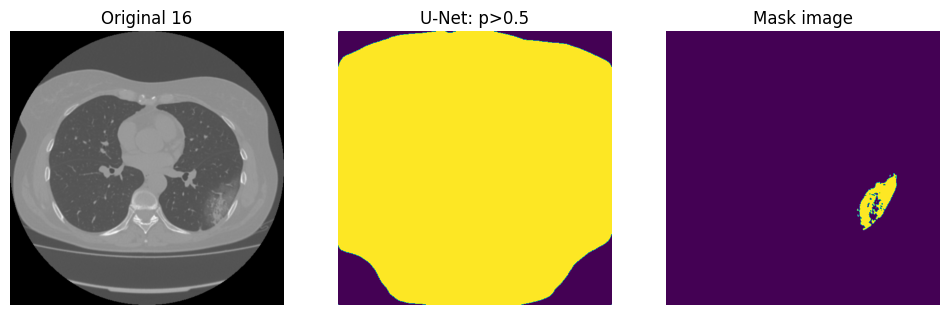

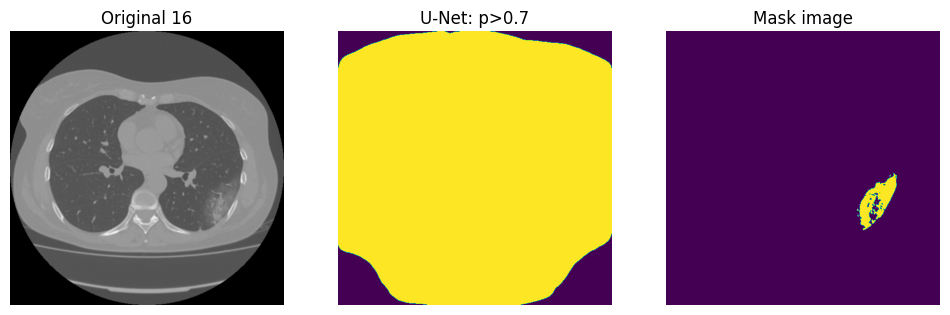

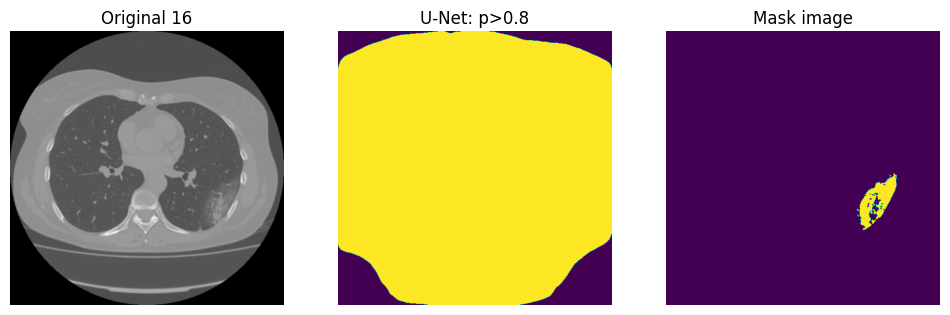

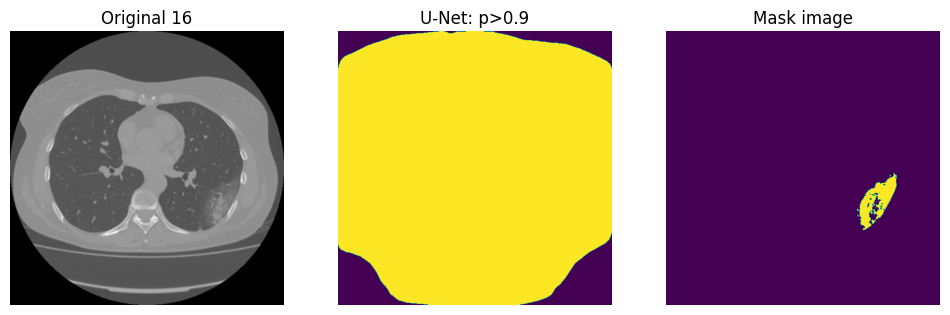

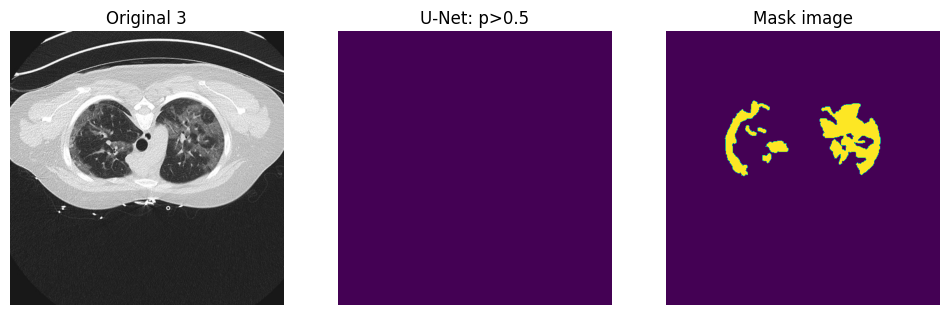

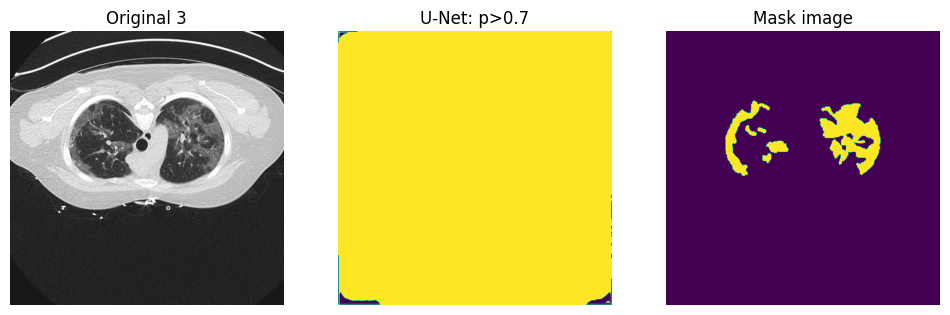

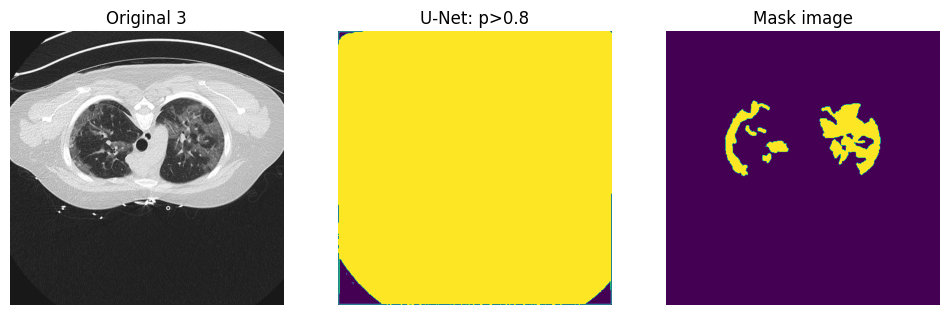

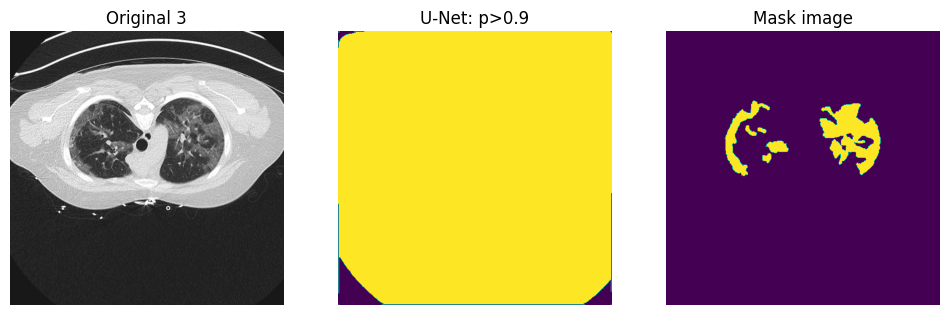

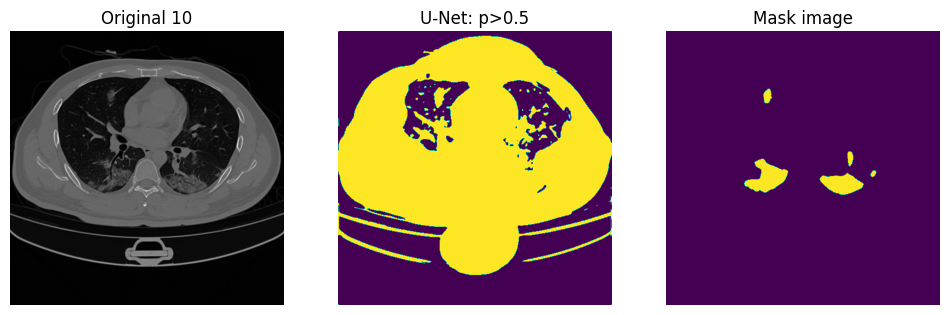

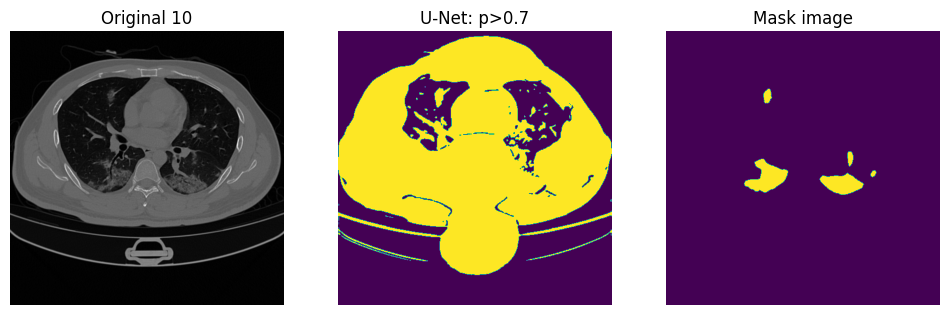

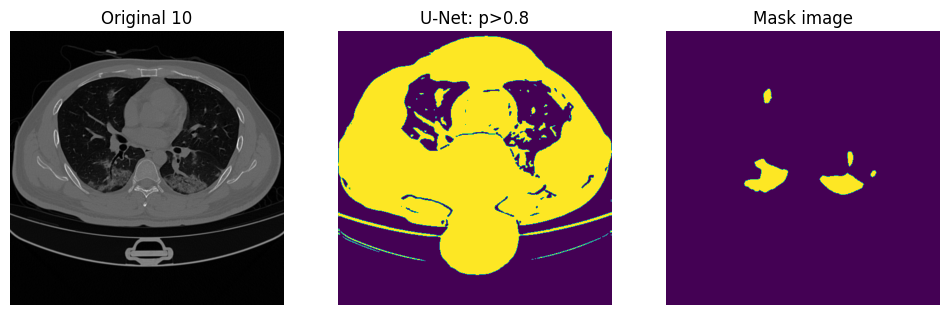

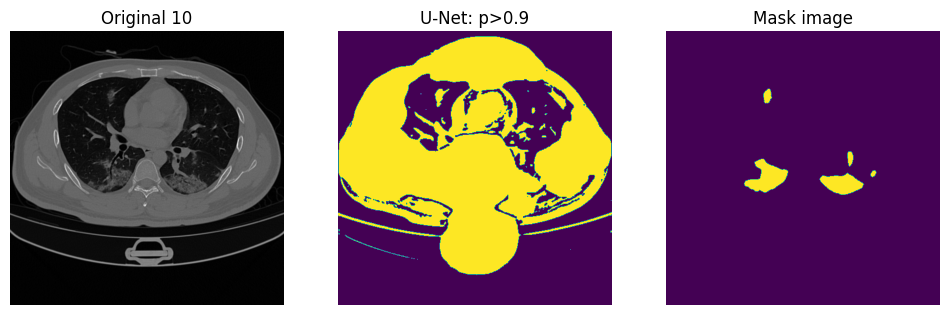

In [200]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()